## Bayesian Network Structure Playground

Current structure simply uses the top 50 or so correlated features (use_top_corrs) and adds them as edges to the network, no structure learning or network optimization has been done; the current structure is a bit random, only using correlated feature data. Running through some of the train data, the current network currently correctly predicts the target within the top 3, 37.6% of the time. Considering the facts that this was sort of a random guess at model structure and that there are 206 targets to choose from (Expected value 3/206 = 1.4% for random guessing), the model type seems to be showing some promise. Ideas for future development:

1. Since the network runs slowly at only 25-30 nodes, we will need to find a way to include information for more features.
    -the final network may need to be much more sparse, only using very select proven connections. How to find these?

2. For simplicity sake, features are currently encoded as high / low (1, 0). This may be causing a large information loss. Potentially decide on a better discretezation scheme. One idea I had for this is simply using mean +- stddev buckets based on the distribution of each feature (they seem to all be roughly normal).

3. Somehow optimize directionality of connections: g-0 --> g-1 or g-1 --> g-0? 
    -maybe iteratively flip connections in many different networks and see if certain directionality of connections works
    better on average.
    -I've currently only studied Bayesian Networks, but perhaps an undirected structure would better fit this problem

4. Could we use a clustering algorithm on the principal components as a precursor to this model? Even looking at only the first two principle components, there are some very obvious clusters. Maybe we could tell the Bayes Net which answers are wrong right out the gate.

5. Ideal parent search: look into this
    -https://jmlr.csail.mit.edu/papers/volume8/elidan07a/elidan07a.pdf
    
6. This paper uses a constraint based two-step clustering and connecting approach. Form clusters of nodes, then decide connectivity of clusters. Just from a theoretical perspective, this seems to fit the biological gene expression paradigm.
    -https://zhangyk8.github.io/publications/Thesis.pdf
    
7. This paper outlines methods of constraining and scoring Bayesian Networks
    -https://jmlr.csail.mit.edu/papers/volume12/decampos11a/decampos11a.pdf

In [1]:
import pandas as pd
from pgmpy.models import BayesianModel
from tqdm import tqdm
import numpy as np
from pgmpy.inference import VariableElimination
import random
import networkx as nx
import pylab as plt

In [2]:
train_df = pd.read_csv('train_features_binary.csv')
train_df.drop('Unnamed: 0',inplace=True,axis=1)

In [3]:
corr_df = pd.read_csv('feature_correlation.csv')
corr_df.drop('Unnamed: 0',inplace=True,axis=1)

In [5]:
use_top_corrs = 5000

#get network connections
#network looks like [(node1,node2),...]
network = []
for i in range(len(corr_df[:use_top_corrs])):
    network.append((corr_df['feature1'][i],corr_df['feature2'][i]))

In [7]:
model = BayesianModel([network[0]])

#constraints
max_parents = 2
max_children = 2

#add edges - pgmpy automatically errors if edge does not form DAG use try / except to ensure DAG
nodes_added = []
for edge in network[1:]:
        #whichever has more children 
        #Node A
        try:
            if edge[0] in nodes_added and edge[1] in nodes_added: #both already in network
                if len(model.get_children(edge[0])) < max_children and len(model.get_children(edge[1])) < max_children:
                    if len(model.get_parents(edge[0])) < max_parents and len(model.get_parents(edge[1])) < max_parents:
                        add_first = random.choice([0,1])
                        model.add_edge(edge[add_first],edge[1-add_first])
                            
                    if len(model.get_parents(edge[0])) < max_parents and len(model.get_parents(edge[1])) >= max_parents:
                        model.add_edge(edge[1],edge[0])
                            
                    if len(model.get_parents(edge[0])) >= max_parents and len(model.get_parents(edge[1])) < max_parents:
                        model.add_edge(edge[0],edge[1])
                        
                if len(model.get_children(edge[0])) < max_children and len(model.get_children(edge[1])) >= max_children and len(model.get_parents(edge[1])) < max_parents:
                    model.add_edge(edge[0],edge[1])
                            
                if len(model.get_children(edge[0])) >= max_children and len(model.get_children(edge[1])) < max_children and len(model.get_parents(edge[0])) < max_parents:
                    model.add_edge(edge[1],edge[0])
                        
            elif edge[0] in nodes_added and edge[1] not in nodes_added: #Node A in network Node B not in network
                if len(model.get_children(edge[0])) < max_children:
                    model.add_edge(edge[0],edge[1])
                    nodes_added.append(edge[1])
                        
            elif edge[0] not in nodes_added and edge[1] in nodes_added: #Node A not in network Node B in network
                if len(model.get_children(edge[1])) < max_children:
                    model.add_edge(edge[1],edge[0])
                    nodes_added.append(edge[0])
                    
            else:
                #neither in network, choose randomly
                add_first = random.choice([0,1])
                model.add_edge(edge[add_first],edge[1-add_first])
                nodes_added.append(edge[add_first])
                nodes_added.append(edge[1-add_first])
                    
        except ValueError: #catch non-DAG error
            pass
        
#if node is leaf, connect to target
for node in nodes_added:
    #print(len(model.get_children(node)))
    #print(len(model.get_parents(node)))
    if node in model.get_leaves():
        model.add_edge(node,'target')

In [8]:
#model.fit automatically finds cpds for each node
model.fit(train_df)

#compute variable eliminations for node independencies to speed up model 
infer = VariableElimination(model)

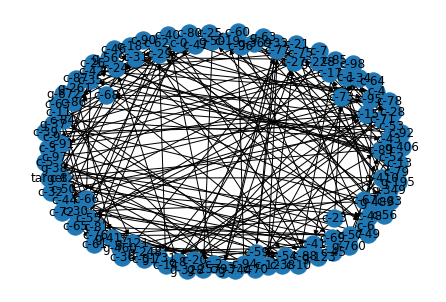

In [9]:
nx.draw(model, with_labels=True)
plt.show()

In [10]:
# get samples to check training data accuracy 
# evidence dict looks like {0 : {'g-0' : 0,'g-1' : 1,...}, 1 : {'g-0' : 0,'g-1' : 1,...},...}
evidence = {}
for i in tqdm(range(len(train_df))):
    evidence[i] = {}
    for node in nodes_added:
        evidence[i][node] = train_df[node][i]

100%|██████████████████████████████████████████████████████████████████████████| 16844/16844 [00:08<00:00, 1991.56it/s]


In [ ]:
# check if actual target is within top 'n' predictions and calculation accuracy over 'total' samples
n = 3
preds = []
count_correct = 0
total = 100

for i in tqdm(range(total)):
    preds = []
    q = infer.query(variables=['target'],evidence=evidence[i],show_progress=False)
    top_n_idx = np.argsort(q.values)[-n:]
    top_n_values = [q.values[i] for i in top_n_idx]
    actual_target = train_df['target'][i]
    if i == 6:
        print('Sample prediciton \n') #obviously I chose one that is a correct prediction
        print(f'Actual Target: {actual_target}')
        print('Predicted Target: \n')
    for j,k in enumerate(top_n_idx):
        name = q.state_names['target'][k]
        preds.append(name)
        if i == 6:
            print(f'{name}: {top_n_values[j]}')
    if i % 10 == 9:
        print(f'running accuracy: {count_correct / i}')
        
    if actual_target in preds:
        count_correct += 1
        
              
print(f'% in top {n}: {count_correct / total * 100}')


In [12]:
print(f'Sample table of target probability distribution \n')
print(q)

Sample table of target probability distribution 

+---------------------------------------------------------+---------------+
| target                                                  |   phi(target) |
+=========================================================+===============+
| target(11-beta-hsd1_inhibitor)                          |        0.0000 |
+---------------------------------------------------------+---------------+
| target(5-alpha_reductase_inhibitor)                     |        0.0000 |
+---------------------------------------------------------+---------------+
| target(acat_inhibitor)                                  |        0.0000 |
+---------------------------------------------------------+---------------+
| target(acetylcholine_receptor_agonist)                  |        0.0909 |
+---------------------------------------------------------+---------------+
| target(acetylcholine_receptor_antagonist)               |        0.0000 |
+-------------------------------------

In [13]:
test_df = pd.read_csv('test_features_binary.csv')
test_df.drop(['Unnamed: 0'],inplace=True,axis=1)
samp_sub = pd.read_csv('sample_submission.csv')

In [16]:
evidence = {}
for i in tqdm(range(len(test_df))):
    evidence[i] = {}
    for node in nodes_added:
        evidence[i][node] = test_df[node][i]

100%|████████████████████████████████████████████████████████████████████████████| 3982/3982 [00:01<00:00, 2052.83it/s]


In [17]:
for i in tqdm(range(len(test_df))):
    q = infer.query(variables=['target'],evidence=evidence[i],show_progress=False)
    preds = dict(zip(list(q.state_names['target']),list(q.values)))
    for key in preds.keys():
        samp_sub[key][i] = preds[key]
        samp_sub['sig_id'][i] = test_df['sig_id'][i]

  0%|                                                                                         | 0/3982 [00:00<?, ?it/s]C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
 34%|█████████████████████████▉                                                  | 1362/3982 [48:14<1:32:48,  2.13s/it]


KeyboardInterrupt: 

In [ ]:
samp_sub

In [ ]:
#check if format matches sample submission
#samp_sub_check = pd.read_csv('sample_submission.csv')
#list(samp_sub['sig_id']) == list(samp_sub_check['sig_id'])